### Calculate wave spectra from CSIRO wave partitions

Objectives:
- Calculate wave spectra from wave parameters of ERA5 partitions
- Write it to file to use as input for SWAN

In [1]:
import xarray as xr
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
from matplotlib.collections import PolyCollection

# Define coordinates of boundary conditions

In [16]:
filepath_coords = r'C:\Users\Mariliasr\OneDrive\Documentos\_UFRGS\Mestrado\Dissert\malha_batimetria'
#filepath_coords = '/home/ceco/ondas/marilia/batimetrias'

grid = 'grid_cartesiano_derefined_Marilia.xyz'

filepath_wv = r'C:\Users\Mariliasr\OneDrive\Documentos\_UFRGS\Mestrado\Dissert\datasets\csiro'
#filepath_wv = '/home/ceco/ondas/datasets/csiro'

dataset = 'csiro_wave_2005.nc'

part0 = ['hs0', 'tp0', 'th0', 'ws0']
part1 = ['hs1', 'tp1', 'th1', 'ws1']
part2 = ['hs2', 'tp2', 'th2', 'ws2']
part3 = ['hs3', 'tp3', 'th3', 'ws3']

output_path = r'C:\Users\Mariliasr\OneDrive\Documentos\_UFRGS\Mestrado\Dissert\specs\2005'
outputfilename = 'csiro'

#output_path = '/home/ceco/ondas/marilia/specs'
#outputfilename = 'csiro'

In [3]:
%cd $filepath_coords

C:\Users\Mariliasr\OneDrive\Documentos\_UFRGS\Mestrado\Dissert\malha_batimetria


In [4]:
# Read lat longs of grid

grid_pd = pd.read_csv(grid, header=None, sep='  ', engine='python')
grid_pd = grid_pd.loc[:, [0,1]]

grid_pd.head(2)

,0,1
0,-55.645509,-34.284832
1,-55.590294,-34.316674


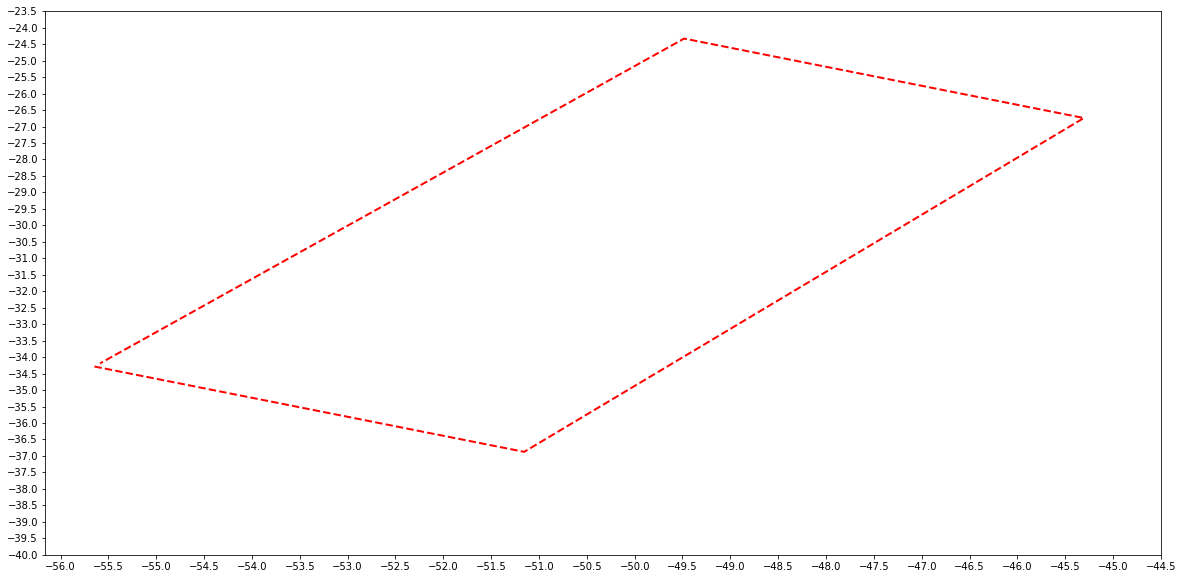

In [5]:
# Plot border of grid
plt.figure(figsize=(20, 10))

x = grid_pd[0]
y = grid_pd[1]

points = grid_pd.values
hull = ConvexHull(points)

plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
plt.xticks(np.arange(-56, -44, 0.5))
plt.yticks(np.arange(-40, -23, 0.5))
plt.show()


In [6]:
vert_NE = [-45.5, -26.5]
vert_NW = [-49.5, -24]
vert_SE = [-51, -36.5]
vert_SW = [-55, -34]

In [7]:
def coord_points(vert1, vert2, resolution):
    import numpy as np
    
    # Create matrix of linear equation ax + b = y from vertices
    a = np.array([[vert1[0], 1], [vert2[0], 1]])
    b = np.array([vert1[1], vert2[1]])
    
    #Calculate a and b
    a, b = np.linalg.solve(a, b)
    
    # Create list of x coords between vertices
    x_coords = np.arange(vert1[0], vert2[0], resolution).tolist()
    y_coords = []
    
    # Calculate y coords from x coords
    for coord in x_coords:
        y = (a*coord) + b
        y_coords.append(y)
    coords = np.column_stack((x_coords, y_coords))
    return coords

In [8]:
coords_north = coord_points(vert_NW, vert_NE, 0.5)
coords_east = coord_points(vert_SE, vert_NE, 0.5)
coords_south = coord_points(vert_SW, vert_SE, 0.5)

coords_tpar = np.vstack((coords_north, coords_east, coords_south))

len(coords_tpar)

27

In [9]:
coords_south


array([[-55.    , -34.    ],
       [-54.5   , -34.3125],
       [-54.    , -34.625 ],
       [-53.5   , -34.9375],
       [-53.    , -35.25  ],
       [-52.5   , -35.5625],
       [-52.    , -35.875 ],
       [-51.5   , -36.1875]])

# Create wave spectra from wave parameters

In [10]:
import xarray as xr
from spec2d import spec2d

In [11]:
%cd $filepath_wv

C:\Users\Mariliasr\OneDrive\Documentos\_UFRGS\Mestrado\Dissert\datasets\csiro


In [12]:
wv_xr = xr.open_dataset(dataset)

In [13]:
wv_xr.var

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:    (latitude: 34, longitude: 33, time: 2160)
Coordinates:
  * longitude  (longitude) float32 -56.0 -55.600006 ... -43.600006 -43.200012
  * latitude   (latitude) float32 -37.2 -36.8 -36.4 -36.0 ... -24.8 -24.4 -24.0
  * time       (time) datetime64[ns] 2005-01-01 ... 2005-03-31T23:00:00.000013440
Data variables:
    hs0        (time, latitude, longitude) float32 ...
    hs1        (time, latitude, longitude) float32 ...
    hs2        (time, latitude, longitude) float32 ...
    hs3        (time, latitude, longitude) float32 ...
    tp0        (time, latitude, longitude) float32 ...
    tp1        (time, latitude, longitude) float32 ...
    tp2        (time, latitude, longitude) float32 ...
    tp3        (time, latitude, longitude) float32 ...
    th0        (time, latitude, longitude) float32 ...
    th1        (time, latitude, longitude) float32 ...
    th2        (time, latitud

In [14]:
# Select desired sites from CSIRO netcdf

wv_points = []

for coord in range(len(coords_tpar)):
    wv_point = wv_xr.sel(dict(latitude=coords_tpar[coord][1],
                             longitude=coords_tpar[coord][0]),
                        method='nearest')
    wv_points.append(wv_point)

In [41]:
wv_xr.close()

In [33]:
# Calculate specs from 1st swell partition

specs_part1 = []
dfs = []

for ds in range(len(wv_points)):
    df = wv_points[ds]
    df = pd.DataFrame(dict(hs=df[part1[0]].values,
                           tp=df[part1[1]].values,
                           pdir=df[part1[2]].values))
    dfs.append(df)
    
for df in dfs:
    loc = []
    for row in df.itertuples():
        spec = spec2d(row.hs, row.tp, row.pdir, 30)
        loc.append(spec)
    specs_part1.append(loc)

specs_part1 = np.array(specs_part1)
specs_part1.shape

(27, 2160, 25, 36)

In [34]:
# Calculate specs from 2nd swell partition

specs_part2 = []
dfs = []

for ds in range(len(wv_points)):
    df = wv_points[ds]
    df = pd.DataFrame(dict(hs=df[part2[0]].values,
                           tp=df[part2[1]].values,
                           pdir=df[part2[2]].values))
    dfs.append(df)
    
for df in dfs:
    loc = []
    for row in df.itertuples():
        spec = spec2d(row.hs, row.tp, row.pdir, 30)
        loc.append(spec)
    specs_part2.append(loc)

specs_part2 = np.array(specs_part2)
specs_part2.shape

(27, 2160, 25, 36)

In [35]:
# Calculate specs from 3rd swell partition

specs_part3 = []
dfs = []

for ds in range(len(wv_points)):
    df = wv_points[ds]
    df = pd.DataFrame(dict(hs=df[part3[0]].values,
                           tp=df[part3[1]].values,
                           pdir=df[part3[2]].values))
    df[df['tp'] == 0] = np.nan
    dfs.append(df)
    
for df in dfs:
    loc = []
    for row in df.itertuples():
        spec = spec2d(row.hs, row.tp, row.pdir, 30)
        loc.append(spec)
    specs_part3.append(loc)

specs_part3 = np.array(specs_part3)
specs_part3.shape

(27, 2160, 25, 36)

In [36]:
# Calculate specs from wind waves

specs_part0 = []
dfs = []

for ds in range(len(wv_points)):
    df = wv_points[ds]
    df = pd.DataFrame(dict(hs=df[part0[0]].values,
                           tp=df[part0[1]].values,
                           pdir=df[part0[2]].values))
    dfs.append(df)
    
for df in dfs:
    loc = []
    for row in df.itertuples():
        spec = spec2d(row.hs, row.tp, row.pdir, 30)
        loc.append(spec)
    specs_part0.append(loc)

specs_part0 = np.array(specs_part0)
specs_part0.shape

(27, 2160, 25, 36)

In [37]:
specs = []
for point in range(len(coords_tpar)):
    loc = []
    for timestamp in range(0, 2160):
        spec = (specs_part0[point][timestamp][:][:] + specs_part1[point][timestamp][:][:]
                + specs_part2[point][timestamp][:][:] + specs_part3[point][timestamp][:][:])
        loc.append(spec)
    specs.append(loc)

specs = np.array(specs)
specs.shape

(27, 2160, 25, 36)

longitude = coords_tpar[0]
latitude = coords_tpar[1]
time = wv_xr.time.values
datetime = pd.to_datetime(time)
f'{datetime[0]:%Y%m%d.%H%M}'

In [38]:
%cd $output_path

C:\Users\Mariliasr\OneDrive\Documentos\_UFRGS\Mestrado\Dissert\specs\2005


In [39]:
np.save('specs_' + outputfilename, specs)

wv_par_xr = xr.concat(wv_points)
wv_par_xr.to_netcdf('wv_par_' + outputfilename + '.nc')

C:\Users\Mariliasr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
specs = np.load('specs_csiro.npy')

In [40]:
longitude = list(xr.concat(wv_points).longitude.values)
latitude = list(xr.concat(wv_points).latitude.values)
time = wv_xr.time.values
datetime = pd.to_datetime(time)

for loc in range(len(coords_tpar)):
    fin = open('specs_' + outputfilename + str(loc+1) + '.bnd', 'w')
    fin.write(
f'''SWAN   1                                Swan standard spectral file, version
$   Data produced by SWAN version 40.51AB             
$   Project:                 ;  run number:     
TIME                                    time-dependent data
     1                                  time coding option
LONLAT                                  locations in spherical coordinates
1
     {longitude[loc]:.6f}      {latitude[loc]:.6f}
AFREQ                                   absolute frequencies in Hz
    25
         0.0500
         0.0566
         0.0642
         0.0727
         0.0824
         0.0933
         0.1057
         0.1198
         0.1357
         0.1538
         0.1742
         0.1974
         0.2236
         0.2533
         0.2870
         0.3252
         0.3684
         0.4174
         0.4729
         0.5357
         0.6070
         0.6877
         0.7791
         0.8827
         1.0000
NDIR                                   spectral nautical directions in degr
36
       0
       10
       20
       30
       40
       50
       60
       70
       80
       90
       100
       110
       120
       130
       140
       150
       160
       170
       180
       190
       200
       210
       220
       230
       240
       250
       260
       270
       280
       290
       300
       310
       320
       330
       340
       350
QUANT
     1                                  number of quantities in table
VaDens                                  variance densities in m2/Hz/degr
m2/Hz/degr                              unit
   -0.9999                              exception value
''')
    fin.close()
    fin=open('specs_' + outputfilename + str(loc+1) + '.bnd', "a+")
    for line in range(0,2160):
        fin.write(
'''{:%Y%m%d.%H%M}
FACTOR
1
{:>10}'''.format(
    datetime[line],
    pd.DataFrame(specs[loc][line][:][:]).to_csv(index=False,
                                               header=False,
                                               sep=',',
                                               float_format='%7.5f',
                                               na_rep= -0.9999)))
    fin = open('specs_' + outputfilename + str(loc+1) + '.bnd', "rt")
    data = fin.read()
    data = data.replace(',', ' ')
    fin.close()
    
    fin = open('specs_' + outputfilename + str(loc+1) + '.bnd', "wt")
    fin.write(data)
    fin.close()

C:\Users\Mariliasr\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'
  """Entry point for launching an IPython kernel.
C:\Users\Mariliasr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'
  
